In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import os
import gc

num_folds = 10

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv("../data/first_round_training_data.csv", encoding='gbk')
labels = data.Quality_label
features = data.drop(["Quality_label"], axis=1)

In [3]:
features.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,6.856075,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,0.000362,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,0.022201,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,1.459004,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,11.576647,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496


In [4]:
one_hot = LabelEncoder()
labels = one_hot.fit_transform(labels)
labels = pd.DataFrame(labels)
labels.head()

,0
0,3
1,1
2,1
3,1
4,1


In [5]:
features.describe()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10
count,6000.000000,6.000000e+03,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6.000000e+03,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03
mean,485.198954,1.952379e+03,406.348529,189.205842,5.868163e+00,5.598597e+00,272.300821,22.133231,5.823664e+04,35.902066,5.351032e+04,8.842895e+04,202.732522,6.271156e+03,1.285985e+06,3.400877e+03,3.166863e+04,4.545394e+05,7.860735e+05,1.989520e+07
std,11401.971393,5.419588e+04,12018.898941,2621.779049,8.631865e+00,7.686898e+00,2027.460514,302.172768,3.173068e+06,101.629348,1.894866e+06,2.854543e+06,2754.503943,2.585508e+05,9.850723e+07,1.999508e+05,1.116889e+06,2.847995e+07,5.885757e+07,1.529785e+09
min,0.000003,1.683797e-07,0.000005,0.000002,9.985942e-07,9.810610e-07,0.000624,0.023699,3.962831e-04,0.001024,6.457597e-10,5.493777e-09,0.000001,4.344229e-06,1.635864e-06,5.456653e-05,4.411611e-03,3.011145e-03,2.366726e-03,1.974795e-03
25%,0.088221,4.765771e-02,0.102304,0.118314,7.416296e-01,3.818154e-01,0.152059,0.035407,5.930812e-01,0.101478,3.100601e-02,3.173294e-02,0.098178,1.319373e-01,1.150362e-01,1.443224e-01,1.135895e-01,1.115708e-01,1.267717e-01,1.253268e-01
50%,1.050304,9.405962e-01,1.044908,1.068467,2.225808e+00,2.684398e+00,0.600827,2.931083,5.930812e-01,0.727611,9.449563e-01,1.030499e+00,0.945947,8.297855e-01,7.539155e-01,9.864325e-01,5.891701e-01,5.922906e-01,6.644951e-01,6.705953e-01
75%,10.938565,1.569199e+01,10.665397,9.902064,6.680183e+00,7.117767e+00,2.374035,17.850021,6.783967e+00,13.969790,2.784766e+01,3.001000e+01,9.803828,6.052952e+00,5.736029e+00,7.422284e+00,4.637157e+00,4.773050e+00,5.571728e+00,4.905501e+00
max,713682.207601,3.034568e+06,864530.632179,139767.494732,8.367195e+01,4.117541e+01,35698.591553,20086.397753,1.738083e+08,517.197610,1.197060e+08,1.615907e+08,128491.084741,1.572225e+07,7.630284e+09,1.488592e+07,7.789923e+07,2.187522e+09,4.558485e+09,1.184961e+11


In [6]:
features = features.drop(['Attribute1','Attribute2','Attribute3','Attribute4','Attribute5',
                          'Attribute6','Attribute7','Attribute8','Attribute9','Attribute10'], axis=1)
features.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385


In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.01, random_state=1)

In [8]:
def kfold_lightgbm(train_df, test_df, y, num_folds, stratified = False, debug= False):
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=17)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=17)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros((train_df.shape[0], 4))
    sub_preds = np.zeros((test_df.shape[0], 4))
    feature_importance_df = pd.DataFrame()
    feats = train_df.columns.tolist()
    test_df = test_df[feats]
    #test_df = csr_matrix(test_df)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y)):
        print('FOLD {}'.format(n_fold))
        train_x, train_y = train_df.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y.iloc[valid_idx]
 
        # LightGBM parameters found by Bayesian optimization
        
        lgb_params =  {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'multiclass',
            #'metric': 'multi_logloss',
            #"n_estimators":10000,
            "learning_rate": 0.001,
            "num_class": 4,
            'num_leaves': 60,
            'subsample': 0.6143,
            'colsample_bytree': 0.6453,
            'min_split_gain': np.power(10, -2.5988),
            'reg_alpha': np.power(10, -2.2887),
            'reg_lambda': np.power(10, 1.7570),
            'min_child_weight': np.power(10, -0.1477),
            'max_depth': -1,
            #'zero_as_missing':True
        }
        
        '''
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'num_leaves': 16,
            'max_depth': -1,
            'min_child_samples': 1,
            'max_bin': 300,
            'subsample': 1.0,
            'subsample_freq': 1,
            'colsample_bytree': 0.5,
            'min_child_weight': 10,
            'reg_lambda': 0.1,
            'reg_alpha': 0.0,
            'scale_pos_weight': 1,
            'zero_as_missing': True,
            'num_threads': -1,
        }
        
        lgb_params = {   
            'task': 'train',
            'boosting_type': 'gbdt', 
            'objective': 'mape',
            'metric': 'mape',
            'learning_rate': 0.01, 
            'num_leaves': 68, 
            'max_depth': 7,                
            'subsample': 0.8, 
            'colsample_bytree': 0.8, 
            'min_child_samples': 20, 
            'min_child_weight': 0.001,
            'bagging_fraction': 1.0, 
            'feature_fraction': 0.7
        }
        '''
        
        lgtrain = lgb.Dataset(train_x, train_y,
                        feature_name=feats) #categorical_feature = 'auto'
        lgvalid = lgb.Dataset(valid_x, valid_y,
                        feature_name=feats)
        clf = lgb.train(
            lgb_params,
            lgtrain,
            num_boost_round=50000, # 50000
            valid_sets=[lgtrain, lgvalid],
            valid_names=['train','valid'],
            early_stopping_rounds=1000,
            verbose_eval=100
        )
        
         
       # clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            #eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)
 
        #oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        sub_preds += clf.predict(test_df, num_iteration=clf.best_iteration)/ folds.n_splits
        clf.save_model("../models/cty_lgb_fold_" + str(n_fold) + ".txt")
         
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance()

        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        print('Fold %2d cross_entropy : %.6f' % (n_fold, log_loss(valid_y, oof_preds[valid_idx])))      
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
 
    cross_entropy = log_loss(y, oof_preds)
    #print('Full AUC score %.6f' % roc_auc_score(y, oof_preds))
    print('Full cross_entropy score %.6f' % cross_entropy)
     
    display_importances(feature_importance_df)
    return feature_importance_df, sub_preds

# 显示特征对于训练的重要性
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 6))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig("../images/cty_importances.png")

FOLD 0
Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_logloss: 1.29274	valid's multi_logloss: 1.30048
[200]	train's multi_logloss: 1.27533	valid's multi_logloss: 1.28841
[300]	train's multi_logloss: 1.25914	valid's multi_logloss: 1.27747
[400]	train's multi_logloss: 1.24418	valid's multi_logloss: 1.26739
[500]	train's multi_logloss: 1.23023	valid's multi_logloss: 1.25817
[600]	train's multi_logloss: 1.21762	valid's multi_logloss: 1.25017
[700]	train's multi_logloss: 1.20586	valid's multi_logloss: 1.243
[800]	train's multi_logloss: 1.19451	valid's multi_logloss: 1.23609
[900]	train's multi_logloss: 1.18422	valid's multi_logloss: 1.2301
[1000]	train's multi_logloss: 1.17467	valid's multi_logloss: 1.22489
[1100]	train's multi_logloss: 1.16577	valid's multi_logloss: 1.22032
[1200]	train's multi_logloss: 1.15715	valid's multi_logloss: 1.216
[1300]	train's multi_logloss: 1.14904	valid's multi_logloss: 1.21215
[1400]	train's multi_logloss: 1.14151	valid's 

[4900]	train's multi_logloss: 0.988488	valid's multi_logloss: 1.10584
[5000]	train's multi_logloss: 0.985098	valid's multi_logloss: 1.10536
[5100]	train's multi_logloss: 0.981753	valid's multi_logloss: 1.10492
[5200]	train's multi_logloss: 0.978486	valid's multi_logloss: 1.10456
[5300]	train's multi_logloss: 0.975229	valid's multi_logloss: 1.10429
[5400]	train's multi_logloss: 0.972023	valid's multi_logloss: 1.10397
[5500]	train's multi_logloss: 0.96891	valid's multi_logloss: 1.10379
[5600]	train's multi_logloss: 0.965797	valid's multi_logloss: 1.10364
[5700]	train's multi_logloss: 0.962706	valid's multi_logloss: 1.10337
[5800]	train's multi_logloss: 0.95963	valid's multi_logloss: 1.10313
[5900]	train's multi_logloss: 0.956581	valid's multi_logloss: 1.10289
[6000]	train's multi_logloss: 0.95359	valid's multi_logloss: 1.10272
[6100]	train's multi_logloss: 0.950633	valid's multi_logloss: 1.10258
[6200]	train's multi_logloss: 0.947692	valid's multi_logloss: 1.10239
[6300]	train's multi_lo

[8400]	train's multi_logloss: 0.89036	valid's multi_logloss: 1.11331
[8500]	train's multi_logloss: 0.887891	valid's multi_logloss: 1.11327
[8600]	train's multi_logloss: 0.885453	valid's multi_logloss: 1.11331
[8700]	train's multi_logloss: 0.883009	valid's multi_logloss: 1.11333
[8800]	train's multi_logloss: 0.880602	valid's multi_logloss: 1.11336
[8900]	train's multi_logloss: 0.8782	valid's multi_logloss: 1.11338
[9000]	train's multi_logloss: 0.875817	valid's multi_logloss: 1.11341
[9100]	train's multi_logloss: 0.873438	valid's multi_logloss: 1.1134
[9200]	train's multi_logloss: 0.871093	valid's multi_logloss: 1.11343
[9300]	train's multi_logloss: 0.868741	valid's multi_logloss: 1.11342
[9400]	train's multi_logloss: 0.866396	valid's multi_logloss: 1.11339
Early stopping, best iteration is:
[8493]	train's multi_logloss: 0.888061	valid's multi_logloss: 1.11326
Fold  2 cross_entropy : 1.113262
FOLD 3
Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_loglo

[1700]	train's multi_logloss: 1.12414	valid's multi_logloss: 1.18626
[1800]	train's multi_logloss: 1.1181	valid's multi_logloss: 1.18328
[1900]	train's multi_logloss: 1.11226	valid's multi_logloss: 1.18046
[2000]	train's multi_logloss: 1.10656	valid's multi_logloss: 1.17767
[2100]	train's multi_logloss: 1.10114	valid's multi_logloss: 1.17516
[2200]	train's multi_logloss: 1.09584	valid's multi_logloss: 1.17286
[2300]	train's multi_logloss: 1.09071	valid's multi_logloss: 1.17057
[2400]	train's multi_logloss: 1.08571	valid's multi_logloss: 1.16842
[2500]	train's multi_logloss: 1.08093	valid's multi_logloss: 1.16659
[2600]	train's multi_logloss: 1.07621	valid's multi_logloss: 1.16471
[2700]	train's multi_logloss: 1.07155	valid's multi_logloss: 1.16288
[2800]	train's multi_logloss: 1.06706	valid's multi_logloss: 1.16122
[2900]	train's multi_logloss: 1.06266	valid's multi_logloss: 1.15971
[3000]	train's multi_logloss: 1.05838	valid's multi_logloss: 1.15839
[3100]	train's multi_logloss: 1.054

[4000]	train's multi_logloss: 1.01826	valid's multi_logloss: 1.13286
[4100]	train's multi_logloss: 1.0146	valid's multi_logloss: 1.13224
[4200]	train's multi_logloss: 1.01105	valid's multi_logloss: 1.13168
[4300]	train's multi_logloss: 1.00751	valid's multi_logloss: 1.13102
[4400]	train's multi_logloss: 1.004	valid's multi_logloss: 1.13039
[4500]	train's multi_logloss: 1.00055	valid's multi_logloss: 1.12991
[4600]	train's multi_logloss: 0.997117	valid's multi_logloss: 1.12943
[4700]	train's multi_logloss: 0.993732	valid's multi_logloss: 1.12881
[4800]	train's multi_logloss: 0.990373	valid's multi_logloss: 1.12826
[4900]	train's multi_logloss: 0.987064	valid's multi_logloss: 1.12781
[5000]	train's multi_logloss: 0.983727	valid's multi_logloss: 1.12728
[5100]	train's multi_logloss: 0.980447	valid's multi_logloss: 1.12685
[5200]	train's multi_logloss: 0.977234	valid's multi_logloss: 1.12644
[5300]	train's multi_logloss: 0.974026	valid's multi_logloss: 1.1261
[5400]	train's multi_logloss: 

[6000]	train's multi_logloss: 0.955126	valid's multi_logloss: 1.10289
[6100]	train's multi_logloss: 0.952192	valid's multi_logloss: 1.10253
[6200]	train's multi_logloss: 0.949258	valid's multi_logloss: 1.10215
[6300]	train's multi_logloss: 0.946373	valid's multi_logloss: 1.10185
[6400]	train's multi_logloss: 0.943462	valid's multi_logloss: 1.10158
[6500]	train's multi_logloss: 0.940589	valid's multi_logloss: 1.10134
[6600]	train's multi_logloss: 0.937761	valid's multi_logloss: 1.10109
[6700]	train's multi_logloss: 0.934968	valid's multi_logloss: 1.10085
[6800]	train's multi_logloss: 0.932173	valid's multi_logloss: 1.10069
[6900]	train's multi_logloss: 0.929394	valid's multi_logloss: 1.10042
[7000]	train's multi_logloss: 0.92665	valid's multi_logloss: 1.10018
[7100]	train's multi_logloss: 0.923909	valid's multi_logloss: 1.09998
[7200]	train's multi_logloss: 0.92122	valid's multi_logloss: 1.09975
[7300]	train's multi_logloss: 0.918527	valid's multi_logloss: 1.09961
[7400]	train's multi_l

[7200]	train's multi_logloss: 0.919899	valid's multi_logloss: 1.10891
[7300]	train's multi_logloss: 0.91721	valid's multi_logloss: 1.10864
[7400]	train's multi_logloss: 0.914561	valid's multi_logloss: 1.10843
[7500]	train's multi_logloss: 0.911925	valid's multi_logloss: 1.10826
[7600]	train's multi_logloss: 0.909287	valid's multi_logloss: 1.10807
[7700]	train's multi_logloss: 0.906683	valid's multi_logloss: 1.10786
[7800]	train's multi_logloss: 0.90409	valid's multi_logloss: 1.10765
[7900]	train's multi_logloss: 0.901533	valid's multi_logloss: 1.10755
[8000]	train's multi_logloss: 0.898977	valid's multi_logloss: 1.10739
[8100]	train's multi_logloss: 0.896456	valid's multi_logloss: 1.1073
[8200]	train's multi_logloss: 0.893932	valid's multi_logloss: 1.10721
[8300]	train's multi_logloss: 0.891436	valid's multi_logloss: 1.10717
[8400]	train's multi_logloss: 0.888962	valid's multi_logloss: 1.10706
[8500]	train's multi_logloss: 0.886466	valid's multi_logloss: 1.10694
[8600]	train's multi_lo

[8300]	train's multi_logloss: 0.89228	valid's multi_logloss: 1.10237
[8400]	train's multi_logloss: 0.889786	valid's multi_logloss: 1.10228
[8500]	train's multi_logloss: 0.887256	valid's multi_logloss: 1.10221
[8600]	train's multi_logloss: 0.884763	valid's multi_logloss: 1.10212
[8700]	train's multi_logloss: 0.882297	valid's multi_logloss: 1.10205
[8800]	train's multi_logloss: 0.879842	valid's multi_logloss: 1.10201
[8900]	train's multi_logloss: 0.877385	valid's multi_logloss: 1.10193
[9000]	train's multi_logloss: 0.87497	valid's multi_logloss: 1.10191
[9100]	train's multi_logloss: 0.872571	valid's multi_logloss: 1.10189
[9200]	train's multi_logloss: 0.870182	valid's multi_logloss: 1.10185
[9300]	train's multi_logloss: 0.867806	valid's multi_logloss: 1.10176
[9400]	train's multi_logloss: 0.86545	valid's multi_logloss: 1.1017
[9500]	train's multi_logloss: 0.863092	valid's multi_logloss: 1.10163
[9600]	train's multi_logloss: 0.86076	valid's multi_logloss: 1.10158
[9700]	train's multi_logl

[8800]	train's multi_logloss: 0.881818	valid's multi_logloss: 1.09591
[8900]	train's multi_logloss: 0.879374	valid's multi_logloss: 1.09588
[9000]	train's multi_logloss: 0.876946	valid's multi_logloss: 1.09577
[9100]	train's multi_logloss: 0.874528	valid's multi_logloss: 1.09571
[9200]	train's multi_logloss: 0.872127	valid's multi_logloss: 1.09564
[9300]	train's multi_logloss: 0.869727	valid's multi_logloss: 1.09553
[9400]	train's multi_logloss: 0.867364	valid's multi_logloss: 1.09556
[9500]	train's multi_logloss: 0.864987	valid's multi_logloss: 1.09552
[9600]	train's multi_logloss: 0.862633	valid's multi_logloss: 1.09551
[9700]	train's multi_logloss: 0.860288	valid's multi_logloss: 1.09551
[9800]	train's multi_logloss: 0.857967	valid's multi_logloss: 1.09549
[9900]	train's multi_logloss: 0.855667	valid's multi_logloss: 1.0955
[10000]	train's multi_logloss: 0.853375	valid's multi_logloss: 1.09553
[10100]	train's multi_logloss: 0.851091	valid's multi_logloss: 1.09561
[10200]	train's mul

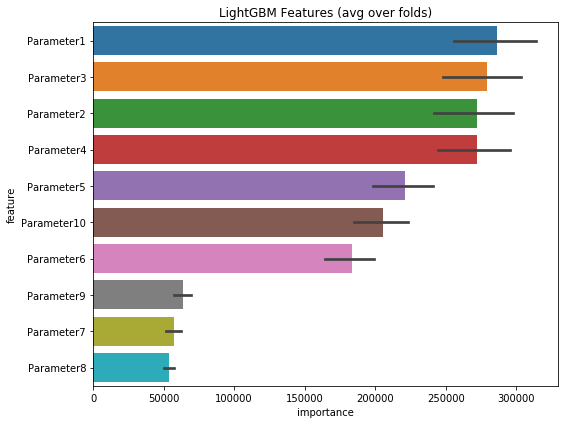

In [9]:
feature_importance, test_score = kfold_lightgbm(x_train, x_test, y_train, num_folds)

In [10]:
test_score

array([[0.17638937, 0.13184732, 0.39907182, 0.29269149],
       [0.39160302, 0.04763022, 0.29490647, 0.26586028],
       [0.11455103, 0.01449741, 0.07876241, 0.79218916],
       [0.09951675, 0.27502388, 0.22765387, 0.39780549],
       [0.07072258, 0.35307108, 0.40138738, 0.17481895],
       [0.12674707, 0.27782726, 0.18943655, 0.40598911],
       [0.37973013, 0.07235286, 0.38436693, 0.16355008],
       [0.08982785, 0.30169809, 0.26893533, 0.33953872],
       [0.32560361, 0.07698432, 0.31857421, 0.27883786],
       [0.32001201, 0.04636633, 0.27777853, 0.35584313],
       [0.16765626, 0.07306425, 0.16909747, 0.59018202],
       [0.3340567 , 0.03800863, 0.47767494, 0.15025973],
       [0.06961097, 0.03250415, 0.16461934, 0.73326554],
       [0.19376802, 0.04126379, 0.16770308, 0.59726511],
       [0.20702828, 0.24341987, 0.39928688, 0.15026496],
       [0.27221458, 0.04841467, 0.46314805, 0.2162227 ],
       [0.4475509 , 0.04291878, 0.35476551, 0.15476482],
       [0.39344314, 0.04696518,

In [11]:
def score_to_pred(test_score):
    test_pred = []
    for i in range(len(test_score)):
        test_pred.append(np.argmax(test_score[i]))
    return test_pred

def evaluate(y_test, test_pred):
    score = 0
    for i in range(len(test_pred)):
        if y_test.values[i] == test_pred[i]:
            score += 1     
    score = float(score) / len(test_pred)
    return score

test_pred = score_to_pred(test_score)
score = evaluate(y_test, test_pred)
score

0.45

In [12]:
test_data = pd.read_csv("../data/first_round_testing_data.csv", encoding='gbk')
test_data.head()

,Group,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0,0.235279,0.195680,0.351488,0.186814,0.086456,1.434060,1.230409,0.038483,2.931083,2.005852
1,0,0.043799,0.523976,32.590688,0.886285,29.702490,0.027434,0.016852,0.600827,0.118077,887.611257
2,0,21.466737,0.523976,11.847792,79499.554454,13544.605343,0.027434,0.016852,0.600827,0.118077,887.611257
3,0,0.703795,0.010192,0.018080,317.015599,38.087562,0.428092,0.314162,0.038483,17.850021,0.051850
4,0,10.447960,0.010192,15.983891,0.996049,16.715690,0.477823,0.464037,0.038483,17.850021,0.051850


In [13]:
pred_df = pd.DataFrame()
test_features = test_data.drop(["Group"], axis=1)
test_features.head()

,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9
0,0.235279,0.195680,0.351488,0.186814,0.086456,1.434060,1.230409,0.038483,2.931083,2.005852
1,0.043799,0.523976,32.590688,0.886285,29.702490,0.027434,0.016852,0.600827,0.118077,887.611257
2,21.466737,0.523976,11.847792,79499.554454,13544.605343,0.027434,0.016852,0.600827,0.118077,887.611257
3,0.703795,0.010192,0.018080,317.015599,38.087562,0.428092,0.314162,0.038483,17.850021,0.051850
4,10.447960,0.010192,15.983891,0.996049,16.715690,0.477823,0.464037,0.038483,17.850021,0.051850


In [14]:
test_pred_df = pd.DataFrame()
models = os.listdir("../models")
pred_list = []
count = 0
for model in models:
    if 'cty' in model:
        filename = "../models/" + model
        clf = lgb.Booster(model_file=filename)
        test_score = clf.predict(test_features, num_iteration=clf.best_iteration)
        test_pred = score_to_pred(test_score)
        test_pred_df[str(count)] = test_pred
        count += 1

test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,0,0,3,3,0,0,3,3,0,0,3,3,0,0,3,0,0,3,3
1,3,0,0,3,3,0,0,3,3,0,0,3,3,0,0,3,0,0,3,3
2,3,0,0,2,3,0,0,3,3,0,0,3,3,0,0,2,0,0,3,2
3,2,0,0,2,2,0,0,2,2,0,0,2,2,0,0,2,0,0,2,2
4,1,0,0,1,2,0,0,1,1,0,0,2,1,0,0,2,0,0,1,1


In [15]:
pred = []
for j in range(len(test_pred_df)):
    arr = test_pred_df[test_pred_df.index == j].values
    count_arr =sorted([[np.sum(arr==i),i] for i in set(arr.flat)])
    pred.append(count_arr[-1][1])

test_data["pred"] = pred

test_data

,Group,Parameter1,Parameter10,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,pred
0,0,0.235279,0.195680,0.351488,0.186814,8.645558e-02,1.434060,1.230409,0.038483,2.931083,2.005852e+00,0
1,0,0.043799,0.523976,32.590688,0.886285,2.970249e+01,0.027434,0.016852,0.600827,0.118077,8.876113e+02,3
2,0,21.466737,0.523976,11.847792,79499.554454,1.354461e+04,0.027434,0.016852,0.600827,0.118077,8.876113e+02,0
3,0,0.703795,0.010192,0.018080,317.015599,3.808756e+01,0.428092,0.314162,0.038483,17.850021,5.184951e-02,2
4,0,10.447960,0.010192,15.983891,0.996049,1.671569e+01,0.477823,0.464037,0.038483,17.850021,5.184951e-02,0
5,0,733.439920,0.010192,99.698641,3.202776,3.136804e+01,0.477823,0.464037,0.038483,17.850021,5.184951e-02,0
6,0,0.149962,0.010192,2.910066,2.187656,3.317446e+02,0.533331,0.464037,0.038483,17.850021,5.184951e-02,2
7,0,0.060635,0.010192,0.016492,0.007373,7.183437e+03,0.533331,0.464037,0.038483,17.850021,5.184951e-02,2
8,0,971.284623,0.010192,29.954312,3.639672,1.363832e-01,0.477823,0.381815,0.038483,17.850021,5.184951e-02,0
9,0,1372.664549,0.010192,2.103451,0.531944,5.802723e+00,0.477823,0.464037,0.038483,17.850021,5.184951e-02,2


In [16]:
count = [i for i in range(120)]
pred_df = pd.DataFrame()
pred_df["Group"] = count
pred_df["Excellent ratio"] = np.zeros(120)
pred_df["Good ratio"] = np.zeros(120)
pred_df["Pass ratio"] = np.zeros(120)
pred_df["Fail ratio"] = np.zeros(120)

for j in range(len(pred_df)):
    pred_arr = test_data[test_data["Group"] == j]["pred"].values
    count_arr =[[np.sum(pred_arr==i),i] for i in set(pred_arr.flat)]

    for i in range(len(count_arr)):
        count_arr[i][0] = count_arr[i][0] / 50.0
        if count_arr[i][1] == 0:
            pred_df.loc[j, "Excellent ratio"] = count_arr[i][0]
        if count_arr[i][1] == 1:
            pred_df.loc[j, "Fail ratio"] = count_arr[i][0]
        if count_arr[i][1] == 2:
            pred_df.loc[j, "Good ratio"] = count_arr[i][0]
        if count_arr[i][1] == 3:
            pred_df.loc[j, "Pass ratio"] = count_arr[i][0]

pred_df.head()

,Group,Excellent ratio,Good ratio,Pass ratio,Fail ratio
0,0,0.46,0.10,0.44,0.00
1,1,0.28,0.12,0.54,0.06
2,2,0.04,0.04,0.90,0.02
3,3,0.18,0.12,0.62,0.08
4,4,0.20,0.22,0.42,0.16


In [17]:
pred_df.to_csv("../data/cty_lgb_baseline.csv", index=False)